# Analytics Vidya Hackathon Computer Vision June-2020

Link: https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/

Team:
- Praveen Raghuvanshi
- Suman Kanukollu

### References
- [How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](
https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)



# Setup

In [ ]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/jantahackathon/data'

/content/drive/My Drive/jantahackathon/data


In [ ]:
!ls

full	jantahackathon.pth  train.csv
images	test_vc2kHdQ.csv    train_SOaYf6m.zip


# Install Extensions

In [ ]:
!pip install ipython-autotime
%load_ext autotime

# Constants, import libraries

In [ ]:
# Constants
TEST_CSV = '/content/drive/My Drive/jantahackathon/data/test_vc2kHdQ.csv'

TRAIN_CSV = '/content/drive/My Drive/jantahackathon/data/train.csv'
TOTAL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/full'
TOTAL_IMAGES_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/emergency'
TOTAL_IMAGES_NOT_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/notemergency'
TRAIN_ZIP = '/content/drive/My Drive/jantahackathon/data/train_SOaYf6m.zip'
ALL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/images'

time: 4.34 ms


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from skimage.io import imread
from tqdm import tqdm

%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

time: 517 ms


# Preview Test CSV

In [ ]:
test_dataframe = pd.read_csv(TEST_CSV)

time: 9.41 ms


In [ ]:
test_dataframe.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


time: 15 ms


In [ ]:
test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  706 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB
time: 5.96 ms


# Preview Train CSV

In [ ]:
train_dataframe = pd.read_csv(TRAIN_CSV)

time: 6.73 ms


In [ ]:
train_dataframe.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


time: 12.5 ms


In [ ]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB
time: 7.69 ms


# Images

In [ ]:
# all_images = os.listdir(ALL_IMAGES_PATH)
# print('Total images: ', len(all_images))

time: 668 µs


In [ ]:
'''import shutil 

for row in train_dataframe.itertuples():
  img_name = row.image_names
  emergency_or_not = row.emergency_or_not
  source = ALL_IMAGES_PATH + '/' + str(img_name)
  if emergency_or_not == 1:   
    destination = TRAIN_IMAGES_EMERGENCY_PATH + '/' + str(img_name)
  if emergency_or_not == 0:   
    destination = TRAIN_IMAGES_NOT_EMERGENCY_PATH + '/' + str(img_name)
  
  dest = shutil.copyfile(source, destination)
  print(dest) '''


"import shutil \n\nfor row in train_dataframe.itertuples():\n  img_name = row.image_names\n  emergency_or_not = row.emergency_or_not\n  source = ALL_IMAGES_PATH + '/' + str(img_name)\n  if emergency_or_not == 1:   \n    destination = TRAIN_IMAGES_EMERGENCY_PATH + '/' + str(img_name)\n  if emergency_or_not == 0:   \n    destination = TRAIN_IMAGES_NOT_EMERGENCY_PATH + '/' + str(img_name)\n  \n  dest = shutil.copyfile(source, destination)\n  print(dest) "

time: 2.85 ms


In [ ]:
print(len(os.listdir(TOTAL_IMAGES_EMERGENCY_PATH)))
print(len(os.listdir(TOTAL_IMAGES_NOT_EMERGENCY_PATH)))

681
965
time: 43.8 s


# Load Dataset

In [ ]:
data_dir = TOTAL_IMAGES_PATH
def load_split_train_test(datadir, valid_size = .2):
    
    train_transforms = transforms.Compose([transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.ToTensor(),])

    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader

time: 11.8 ms


In [ ]:
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['emergency', 'notemergency']
time: 41.2 ms


# Display Images

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def display(noofimages, trainloader, classes):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    maximagescount = labels.size()[0]
    print(maximagescount)
    print(len(images))
    if noofimages > maximagescount:
        raise ValueError('The no of images must be less than ' + maximagescount)

    # show images
    imshow(torchvision.utils.make_grid(images[:5]))

    # display labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(noofimages)))

time: 7.08 ms


## Train Samples

16
16
emergency emergency emergency notemergency notemergency


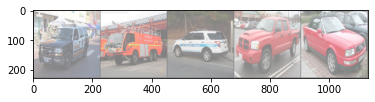

time: 5.45 s


In [ ]:
# Display train samples
display(5, trainloader, trainloader.dataset.classes)

# Test Samples

16
16
notemergency notemergency notemergency notemergency emergency


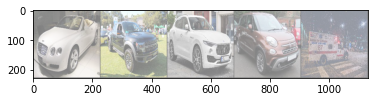

time: 5.26 s


In [ ]:
# Display Test samples
display(5, testloader, testloader.dataset.classes)

# Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

### Freeze and modify final layer

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))

time: 17.1 ms


## Loss and Optimizer

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 9.45 s


## Training - Train

In [ ]:
epochs = 100
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in tqdm(range(epochs)):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'jantahackathon.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100.. Train loss: 1.590.. Test loss: 0.331.. Test accuracy: 0.899
Epoch 1/100.. Train loss: 0.521.. Test loss: 0.394.. Test accuracy: 0.826
Epoch 1/100.. Train loss: 0.508.. Test loss: 0.343.. Test accuracy: 0.858
Epoch 1/100.. Train loss: 0.381.. Test loss: 0.320.. Test accuracy: 0.867
Epoch 1/100.. Train loss: 0.200.. Test loss: 0.218.. Test accuracy: 0.923
Epoch 1/100.. Train loss: 0.303.. Test loss: 0.240.. Test accuracy: 0.920
Epoch 1/100.. Train loss: 0.229.. Test loss: 0.226.. Test accuracy: 0.895
Epoch 1/100.. Train loss: 0.268.. Test loss: 0.214.. Test accuracy: 0.902


  1%|          | 1/100 [08:12<13:31:51, 492.04s/it]

Epoch 2/100.. Train loss: 0.351.. Test loss: 0.315.. Test accuracy: 0.874
Epoch 2/100.. Train loss: 0.264.. Test loss: 0.537.. Test accuracy: 0.790
Epoch 2/100.. Train loss: 0.498.. Test loss: 0.255.. Test accuracy: 0.905
Epoch 2/100.. Train loss: 0.414.. Test loss: 0.221.. Test accuracy: 0.908
Epoch 2/100.. Train loss: 0.391.. Test loss: 0.229.. Test accuracy: 0.902
Epoch 2/100.. Train loss: 0.267.. Test loss: 0.209.. Test accuracy: 0.902
Epoch 2/100.. Train loss: 0.239.. Test loss: 0.197.. Test accuracy: 0.911
Epoch 2/100.. Train loss: 0.307.. Test loss: 0.204.. Test accuracy: 0.914


  2%|▏         | 2/100 [08:29<9:30:52, 349.52s/it] 

Epoch 3/100.. Train loss: 0.291.. Test loss: 0.223.. Test accuracy: 0.906
Epoch 3/100.. Train loss: 0.240.. Test loss: 0.279.. Test accuracy: 0.903
Epoch 3/100.. Train loss: 0.203.. Test loss: 0.191.. Test accuracy: 0.908
Epoch 3/100.. Train loss: 0.221.. Test loss: 0.298.. Test accuracy: 0.870
Epoch 3/100.. Train loss: 0.298.. Test loss: 0.197.. Test accuracy: 0.911
Epoch 3/100.. Train loss: 0.212.. Test loss: 0.209.. Test accuracy: 0.909
Epoch 3/100.. Train loss: 0.368.. Test loss: 0.232.. Test accuracy: 0.920
Epoch 3/100.. Train loss: 0.361.. Test loss: 0.304.. Test accuracy: 0.878


  3%|▎         | 3/100 [08:46<6:44:07, 249.97s/it]

Epoch 4/100.. Train loss: 0.200.. Test loss: 0.208.. Test accuracy: 0.920
Epoch 4/100.. Train loss: 0.171.. Test loss: 0.232.. Test accuracy: 0.920
Epoch 4/100.. Train loss: 0.250.. Test loss: 0.457.. Test accuracy: 0.803
Epoch 4/100.. Train loss: 0.317.. Test loss: 0.194.. Test accuracy: 0.923
Epoch 4/100.. Train loss: 0.257.. Test loss: 0.222.. Test accuracy: 0.920
Epoch 4/100.. Train loss: 0.276.. Test loss: 0.201.. Test accuracy: 0.920
Epoch 4/100.. Train loss: 0.297.. Test loss: 0.298.. Test accuracy: 0.893
Epoch 4/100.. Train loss: 0.350.. Test loss: 0.215.. Test accuracy: 0.917


  4%|▍         | 4/100 [09:05<4:48:58, 180.61s/it]

Epoch 4/100.. Train loss: 0.188.. Test loss: 0.188.. Test accuracy: 0.929
Epoch 5/100.. Train loss: 0.212.. Test loss: 0.194.. Test accuracy: 0.918
Epoch 5/100.. Train loss: 0.207.. Test loss: 0.190.. Test accuracy: 0.920
Epoch 5/100.. Train loss: 0.331.. Test loss: 0.286.. Test accuracy: 0.870
Epoch 5/100.. Train loss: 0.284.. Test loss: 0.200.. Test accuracy: 0.914
Epoch 5/100.. Train loss: 0.248.. Test loss: 0.300.. Test accuracy: 0.902
Epoch 5/100.. Train loss: 0.214.. Test loss: 0.245.. Test accuracy: 0.896
Epoch 5/100.. Train loss: 0.305.. Test loss: 0.261.. Test accuracy: 0.891
Epoch 5/100.. Train loss: 0.266.. Test loss: 0.309.. Test accuracy: 0.890


  5%|▌         | 5/100 [09:22<3:28:18, 131.56s/it]

Epoch 6/100.. Train loss: 0.280.. Test loss: 0.210.. Test accuracy: 0.917
Epoch 6/100.. Train loss: 0.264.. Test loss: 0.192.. Test accuracy: 0.926
Epoch 6/100.. Train loss: 0.274.. Test loss: 0.191.. Test accuracy: 0.926
Epoch 6/100.. Train loss: 0.162.. Test loss: 0.201.. Test accuracy: 0.915
Epoch 6/100.. Train loss: 0.181.. Test loss: 0.233.. Test accuracy: 0.897
Epoch 6/100.. Train loss: 0.210.. Test loss: 0.211.. Test accuracy: 0.917
Epoch 6/100.. Train loss: 0.145.. Test loss: 0.200.. Test accuracy: 0.917
Epoch 6/100.. Train loss: 0.162.. Test loss: 0.188.. Test accuracy: 0.923


  6%|▌         | 6/100 [09:39<2:32:18, 97.22s/it] 

Epoch 7/100.. Train loss: 0.223.. Test loss: 0.220.. Test accuracy: 0.905
Epoch 7/100.. Train loss: 0.315.. Test loss: 0.244.. Test accuracy: 0.905
Epoch 7/100.. Train loss: 0.252.. Test loss: 0.196.. Test accuracy: 0.926
Epoch 7/100.. Train loss: 0.233.. Test loss: 0.220.. Test accuracy: 0.902
Epoch 7/100.. Train loss: 0.205.. Test loss: 0.196.. Test accuracy: 0.920
Epoch 7/100.. Train loss: 0.215.. Test loss: 0.217.. Test accuracy: 0.905
Epoch 7/100.. Train loss: 0.183.. Test loss: 0.229.. Test accuracy: 0.914
Epoch 7/100.. Train loss: 0.171.. Test loss: 0.229.. Test accuracy: 0.902


  7%|▋         | 7/100 [09:58<1:54:05, 73.60s/it]

Epoch 7/100.. Train loss: 0.160.. Test loss: 0.189.. Test accuracy: 0.929
Epoch 8/100.. Train loss: 0.154.. Test loss: 0.195.. Test accuracy: 0.929
Epoch 8/100.. Train loss: 0.164.. Test loss: 0.185.. Test accuracy: 0.929
Epoch 8/100.. Train loss: 0.291.. Test loss: 0.303.. Test accuracy: 0.861
Epoch 8/100.. Train loss: 0.201.. Test loss: 0.229.. Test accuracy: 0.905
Epoch 8/100.. Train loss: 0.212.. Test loss: 0.192.. Test accuracy: 0.923
Epoch 8/100.. Train loss: 0.235.. Test loss: 0.217.. Test accuracy: 0.911
Epoch 8/100.. Train loss: 0.229.. Test loss: 0.260.. Test accuracy: 0.908
Epoch 8/100.. Train loss: 0.252.. Test loss: 0.201.. Test accuracy: 0.932


  8%|▊         | 8/100 [10:15<1:26:54, 56.68s/it]

Epoch 9/100.. Train loss: 0.236.. Test loss: 0.197.. Test accuracy: 0.917
Epoch 9/100.. Train loss: 0.361.. Test loss: 0.190.. Test accuracy: 0.920
Epoch 9/100.. Train loss: 0.296.. Test loss: 0.551.. Test accuracy: 0.756
Epoch 9/100.. Train loss: 0.420.. Test loss: 0.229.. Test accuracy: 0.915
Epoch 9/100.. Train loss: 0.312.. Test loss: 0.392.. Test accuracy: 0.817
Epoch 9/100.. Train loss: 0.274.. Test loss: 0.424.. Test accuracy: 0.835
Epoch 9/100.. Train loss: 0.309.. Test loss: 0.177.. Test accuracy: 0.929
Epoch 9/100.. Train loss: 0.288.. Test loss: 0.201.. Test accuracy: 0.921


  9%|▉         | 9/100 [10:32<1:07:52, 44.75s/it]

Epoch 10/100.. Train loss: 0.175.. Test loss: 0.206.. Test accuracy: 0.920
Epoch 10/100.. Train loss: 0.228.. Test loss: 0.187.. Test accuracy: 0.917
Epoch 10/100.. Train loss: 0.251.. Test loss: 0.325.. Test accuracy: 0.882
Epoch 10/100.. Train loss: 0.179.. Test loss: 0.222.. Test accuracy: 0.902
Epoch 10/100.. Train loss: 0.265.. Test loss: 0.205.. Test accuracy: 0.917
Epoch 10/100.. Train loss: 0.174.. Test loss: 0.345.. Test accuracy: 0.885
Epoch 10/100.. Train loss: 0.343.. Test loss: 0.234.. Test accuracy: 0.897
Epoch 10/100.. Train loss: 0.180.. Test loss: 0.202.. Test accuracy: 0.918


 10%|█         | 10/100 [10:50<55:17, 36.86s/it] 

Epoch 10/100.. Train loss: 0.211.. Test loss: 0.228.. Test accuracy: 0.909
Epoch 11/100.. Train loss: 0.306.. Test loss: 0.256.. Test accuracy: 0.894
Epoch 11/100.. Train loss: 0.187.. Test loss: 0.203.. Test accuracy: 0.917
Epoch 11/100.. Train loss: 0.250.. Test loss: 0.225.. Test accuracy: 0.908
Epoch 11/100.. Train loss: 0.268.. Test loss: 0.232.. Test accuracy: 0.899
Epoch 11/100.. Train loss: 0.176.. Test loss: 0.200.. Test accuracy: 0.917
Epoch 11/100.. Train loss: 0.207.. Test loss: 0.239.. Test accuracy: 0.914
Epoch 11/100.. Train loss: 0.176.. Test loss: 0.268.. Test accuracy: 0.911


 11%|█         | 11/100 [11:07<45:51, 30.92s/it]

Epoch 11/100.. Train loss: 0.304.. Test loss: 0.183.. Test accuracy: 0.935
Epoch 12/100.. Train loss: 0.251.. Test loss: 0.203.. Test accuracy: 0.919
Epoch 12/100.. Train loss: 0.196.. Test loss: 0.193.. Test accuracy: 0.932
Epoch 12/100.. Train loss: 0.347.. Test loss: 0.231.. Test accuracy: 0.908
Epoch 12/100.. Train loss: 0.216.. Test loss: 0.202.. Test accuracy: 0.920
Epoch 12/100.. Train loss: 0.103.. Test loss: 0.191.. Test accuracy: 0.926
Epoch 12/100.. Train loss: 0.179.. Test loss: 0.206.. Test accuracy: 0.920
Epoch 12/100.. Train loss: 0.118.. Test loss: 0.192.. Test accuracy: 0.926
Epoch 12/100.. Train loss: 0.227.. Test loss: 0.253.. Test accuracy: 0.879


 12%|█▏        | 12/100 [11:24<39:16, 26.77s/it]

Epoch 13/100.. Train loss: 0.235.. Test loss: 0.233.. Test accuracy: 0.920
Epoch 13/100.. Train loss: 0.164.. Test loss: 0.186.. Test accuracy: 0.938
Epoch 13/100.. Train loss: 0.184.. Test loss: 0.223.. Test accuracy: 0.917
Epoch 13/100.. Train loss: 0.152.. Test loss: 0.210.. Test accuracy: 0.914
Epoch 13/100.. Train loss: 0.202.. Test loss: 0.204.. Test accuracy: 0.911
Epoch 13/100.. Train loss: 0.208.. Test loss: 0.193.. Test accuracy: 0.926
Epoch 13/100.. Train loss: 0.138.. Test loss: 0.252.. Test accuracy: 0.908
Epoch 13/100.. Train loss: 0.397.. Test loss: 0.206.. Test accuracy: 0.921


 13%|█▎        | 13/100 [11:41<34:36, 23.87s/it]

Epoch 14/100.. Train loss: 0.285.. Test loss: 0.179.. Test accuracy: 0.926
Epoch 14/100.. Train loss: 0.215.. Test loss: 0.196.. Test accuracy: 0.920
Epoch 14/100.. Train loss: 0.193.. Test loss: 0.193.. Test accuracy: 0.926
Epoch 14/100.. Train loss: 0.230.. Test loss: 0.190.. Test accuracy: 0.920
Epoch 14/100.. Train loss: 0.112.. Test loss: 0.202.. Test accuracy: 0.923
Epoch 14/100.. Train loss: 0.173.. Test loss: 0.193.. Test accuracy: 0.926
Epoch 14/100.. Train loss: 0.215.. Test loss: 0.226.. Test accuracy: 0.923
Epoch 14/100.. Train loss: 0.239.. Test loss: 0.244.. Test accuracy: 0.900


 14%|█▍        | 14/100 [12:00<31:53, 22.25s/it]

Epoch 14/100.. Train loss: 0.200.. Test loss: 0.201.. Test accuracy: 0.911
Epoch 15/100.. Train loss: 0.196.. Test loss: 0.194.. Test accuracy: 0.914
Epoch 15/100.. Train loss: 0.139.. Test loss: 0.195.. Test accuracy: 0.923
Epoch 15/100.. Train loss: 0.164.. Test loss: 0.195.. Test accuracy: 0.923
Epoch 15/100.. Train loss: 0.147.. Test loss: 0.243.. Test accuracy: 0.914
Epoch 15/100.. Train loss: 0.232.. Test loss: 0.206.. Test accuracy: 0.914
Epoch 15/100.. Train loss: 0.224.. Test loss: 0.178.. Test accuracy: 0.932
Epoch 15/100.. Train loss: 0.284.. Test loss: 0.188.. Test accuracy: 0.929
Epoch 15/100.. Train loss: 0.238.. Test loss: 0.182.. Test accuracy: 0.926


 15%|█▌        | 15/100 [12:17<29:20, 20.71s/it]

Epoch 16/100.. Train loss: 0.180.. Test loss: 0.199.. Test accuracy: 0.923
Epoch 16/100.. Train loss: 0.216.. Test loss: 0.193.. Test accuracy: 0.923
Epoch 16/100.. Train loss: 0.228.. Test loss: 0.231.. Test accuracy: 0.914
Epoch 16/100.. Train loss: 0.197.. Test loss: 0.219.. Test accuracy: 0.911
Epoch 16/100.. Train loss: 0.191.. Test loss: 0.176.. Test accuracy: 0.920
Epoch 16/100.. Train loss: 0.204.. Test loss: 0.240.. Test accuracy: 0.899
Epoch 16/100.. Train loss: 0.184.. Test loss: 0.205.. Test accuracy: 0.911
Epoch 16/100.. Train loss: 0.145.. Test loss: 0.208.. Test accuracy: 0.917


 16%|█▌        | 16/100 [12:34<27:26, 19.60s/it]

Epoch 17/100.. Train loss: 0.234.. Test loss: 0.238.. Test accuracy: 0.899
Epoch 17/100.. Train loss: 0.297.. Test loss: 0.305.. Test accuracy: 0.853
Epoch 17/100.. Train loss: 0.163.. Test loss: 0.203.. Test accuracy: 0.902
Epoch 17/100.. Train loss: 0.196.. Test loss: 0.217.. Test accuracy: 0.923
Epoch 17/100.. Train loss: 0.199.. Test loss: 0.185.. Test accuracy: 0.920
Epoch 17/100.. Train loss: 0.215.. Test loss: 0.203.. Test accuracy: 0.908
Epoch 17/100.. Train loss: 0.244.. Test loss: 0.222.. Test accuracy: 0.917
Epoch 17/100.. Train loss: 0.248.. Test loss: 0.174.. Test accuracy: 0.922


 17%|█▋        | 17/100 [12:53<26:37, 19.25s/it]

Epoch 17/100.. Train loss: 0.192.. Test loss: 0.174.. Test accuracy: 0.923
Epoch 18/100.. Train loss: 0.170.. Test loss: 0.167.. Test accuracy: 0.926
Epoch 18/100.. Train loss: 0.106.. Test loss: 0.185.. Test accuracy: 0.926
Epoch 18/100.. Train loss: 0.145.. Test loss: 0.178.. Test accuracy: 0.932
Epoch 18/100.. Train loss: 0.166.. Test loss: 0.207.. Test accuracy: 0.920
Epoch 18/100.. Train loss: 0.259.. Test loss: 0.201.. Test accuracy: 0.932
Epoch 18/100.. Train loss: 0.215.. Test loss: 0.193.. Test accuracy: 0.928
Epoch 18/100.. Train loss: 0.213.. Test loss: 0.161.. Test accuracy: 0.932
Epoch 18/100.. Train loss: 0.212.. Test loss: 0.164.. Test accuracy: 0.932


 18%|█▊        | 18/100 [13:10<25:24, 18.59s/it]

Epoch 19/100.. Train loss: 0.319.. Test loss: 0.235.. Test accuracy: 0.911
Epoch 19/100.. Train loss: 0.181.. Test loss: 0.205.. Test accuracy: 0.920
Epoch 19/100.. Train loss: 0.252.. Test loss: 0.261.. Test accuracy: 0.902
Epoch 19/100.. Train loss: 0.194.. Test loss: 0.183.. Test accuracy: 0.935
Epoch 19/100.. Train loss: 0.154.. Test loss: 0.171.. Test accuracy: 0.929
Epoch 19/100.. Train loss: 0.263.. Test loss: 0.249.. Test accuracy: 0.879
Epoch 19/100.. Train loss: 0.118.. Test loss: 0.232.. Test accuracy: 0.906
Epoch 19/100.. Train loss: 0.155.. Test loss: 0.192.. Test accuracy: 0.911


 19%|█▉        | 19/100 [13:27<24:27, 18.12s/it]

Epoch 20/100.. Train loss: 0.133.. Test loss: 0.190.. Test accuracy: 0.917
Epoch 20/100.. Train loss: 0.174.. Test loss: 0.211.. Test accuracy: 0.929
Epoch 20/100.. Train loss: 0.154.. Test loss: 0.179.. Test accuracy: 0.935
Epoch 20/100.. Train loss: 0.245.. Test loss: 0.211.. Test accuracy: 0.905
Epoch 20/100.. Train loss: 0.238.. Test loss: 0.176.. Test accuracy: 0.932
Epoch 20/100.. Train loss: 0.138.. Test loss: 0.163.. Test accuracy: 0.940
Epoch 20/100.. Train loss: 0.160.. Test loss: 0.242.. Test accuracy: 0.923
Epoch 20/100.. Train loss: 0.185.. Test loss: 0.181.. Test accuracy: 0.932


 20%|██        | 20/100 [13:45<24:20, 18.26s/it]

Epoch 20/100.. Train loss: 0.171.. Test loss: 0.177.. Test accuracy: 0.940
Epoch 21/100.. Train loss: 0.160.. Test loss: 0.190.. Test accuracy: 0.920
Epoch 21/100.. Train loss: 0.238.. Test loss: 0.210.. Test accuracy: 0.914
Epoch 21/100.. Train loss: 0.205.. Test loss: 0.235.. Test accuracy: 0.896
Epoch 21/100.. Train loss: 0.306.. Test loss: 0.242.. Test accuracy: 0.868
Epoch 21/100.. Train loss: 0.199.. Test loss: 0.241.. Test accuracy: 0.919
Epoch 21/100.. Train loss: 0.167.. Test loss: 0.239.. Test accuracy: 0.897
Epoch 21/100.. Train loss: 0.125.. Test loss: 0.240.. Test accuracy: 0.920


 21%|██        | 21/100 [14:03<23:54, 18.16s/it]

Epoch 21/100.. Train loss: 0.161.. Test loss: 0.177.. Test accuracy: 0.935
Epoch 22/100.. Train loss: 0.145.. Test loss: 0.180.. Test accuracy: 0.926
Epoch 22/100.. Train loss: 0.183.. Test loss: 0.167.. Test accuracy: 0.935
Epoch 22/100.. Train loss: 0.198.. Test loss: 0.171.. Test accuracy: 0.929
Epoch 22/100.. Train loss: 0.198.. Test loss: 0.183.. Test accuracy: 0.920
Epoch 22/100.. Train loss: 0.172.. Test loss: 0.180.. Test accuracy: 0.920
Epoch 22/100.. Train loss: 0.258.. Test loss: 0.208.. Test accuracy: 0.905
Epoch 22/100.. Train loss: 0.256.. Test loss: 0.226.. Test accuracy: 0.914
Epoch 22/100.. Train loss: 0.242.. Test loss: 0.199.. Test accuracy: 0.930


 22%|██▏       | 22/100 [14:20<23:11, 17.84s/it]

Epoch 23/100.. Train loss: 0.184.. Test loss: 0.182.. Test accuracy: 0.926
Epoch 23/100.. Train loss: 0.146.. Test loss: 0.232.. Test accuracy: 0.896
Epoch 23/100.. Train loss: 0.122.. Test loss: 0.227.. Test accuracy: 0.917
Epoch 23/100.. Train loss: 0.242.. Test loss: 0.224.. Test accuracy: 0.902
Epoch 23/100.. Train loss: 0.191.. Test loss: 0.196.. Test accuracy: 0.917
Epoch 23/100.. Train loss: 0.208.. Test loss: 0.187.. Test accuracy: 0.917
Epoch 23/100.. Train loss: 0.248.. Test loss: 0.184.. Test accuracy: 0.935
Epoch 23/100.. Train loss: 0.208.. Test loss: 0.193.. Test accuracy: 0.941


 23%|██▎       | 23/100 [14:37<22:39, 17.65s/it]

Epoch 24/100.. Train loss: 0.131.. Test loss: 0.182.. Test accuracy: 0.923
Epoch 24/100.. Train loss: 0.136.. Test loss: 0.185.. Test accuracy: 0.940
Epoch 24/100.. Train loss: 0.131.. Test loss: 0.205.. Test accuracy: 0.925
Epoch 24/100.. Train loss: 0.170.. Test loss: 0.168.. Test accuracy: 0.938
Epoch 24/100.. Train loss: 0.192.. Test loss: 0.171.. Test accuracy: 0.933
Epoch 24/100.. Train loss: 0.180.. Test loss: 0.191.. Test accuracy: 0.920
Epoch 24/100.. Train loss: 0.127.. Test loss: 0.199.. Test accuracy: 0.926
Epoch 24/100.. Train loss: 0.283.. Test loss: 0.197.. Test accuracy: 0.923


 24%|██▍       | 24/100 [14:56<22:43, 17.94s/it]

Epoch 24/100.. Train loss: 0.293.. Test loss: 0.240.. Test accuracy: 0.923
Epoch 25/100.. Train loss: 0.221.. Test loss: 0.178.. Test accuracy: 0.926
Epoch 25/100.. Train loss: 0.198.. Test loss: 0.183.. Test accuracy: 0.929
Epoch 25/100.. Train loss: 0.157.. Test loss: 0.188.. Test accuracy: 0.932
Epoch 25/100.. Train loss: 0.173.. Test loss: 0.184.. Test accuracy: 0.924
Epoch 25/100.. Train loss: 0.241.. Test loss: 0.184.. Test accuracy: 0.944
Epoch 25/100.. Train loss: 0.228.. Test loss: 0.200.. Test accuracy: 0.917
Epoch 25/100.. Train loss: 0.298.. Test loss: 0.182.. Test accuracy: 0.930
Epoch 25/100.. Train loss: 0.152.. Test loss: 0.192.. Test accuracy: 0.917


 25%|██▌       | 25/100 [15:13<22:14, 17.79s/it]

Epoch 26/100.. Train loss: 0.183.. Test loss: 0.176.. Test accuracy: 0.929
Epoch 26/100.. Train loss: 0.173.. Test loss: 0.169.. Test accuracy: 0.938
Epoch 26/100.. Train loss: 0.179.. Test loss: 0.190.. Test accuracy: 0.926
Epoch 26/100.. Train loss: 0.358.. Test loss: 0.289.. Test accuracy: 0.858
Epoch 26/100.. Train loss: 0.174.. Test loss: 0.201.. Test accuracy: 0.917
Epoch 26/100.. Train loss: 0.249.. Test loss: 0.206.. Test accuracy: 0.923
Epoch 26/100.. Train loss: 0.336.. Test loss: 0.243.. Test accuracy: 0.909
Epoch 26/100.. Train loss: 0.316.. Test loss: 0.259.. Test accuracy: 0.887


 26%|██▌       | 26/100 [15:31<21:51, 17.73s/it]

Epoch 27/100.. Train loss: 0.354.. Test loss: 0.261.. Test accuracy: 0.894
Epoch 27/100.. Train loss: 0.481.. Test loss: 0.345.. Test accuracy: 0.891
Epoch 27/100.. Train loss: 0.266.. Test loss: 0.200.. Test accuracy: 0.923
Epoch 27/100.. Train loss: 0.131.. Test loss: 0.186.. Test accuracy: 0.920
Epoch 27/100.. Train loss: 0.220.. Test loss: 0.165.. Test accuracy: 0.932
Epoch 27/100.. Train loss: 0.161.. Test loss: 0.205.. Test accuracy: 0.929
Epoch 27/100.. Train loss: 0.195.. Test loss: 0.178.. Test accuracy: 0.949
Epoch 27/100.. Train loss: 0.159.. Test loss: 0.179.. Test accuracy: 0.932


 27%|██▋       | 27/100 [15:49<21:49, 17.94s/it]

Epoch 27/100.. Train loss: 0.175.. Test loss: 0.177.. Test accuracy: 0.932
Epoch 28/100.. Train loss: 0.174.. Test loss: 0.233.. Test accuracy: 0.917
Epoch 28/100.. Train loss: 0.234.. Test loss: 0.188.. Test accuracy: 0.932
Epoch 28/100.. Train loss: 0.177.. Test loss: 0.184.. Test accuracy: 0.923
Epoch 28/100.. Train loss: 0.159.. Test loss: 0.187.. Test accuracy: 0.911
Epoch 28/100.. Train loss: 0.120.. Test loss: 0.187.. Test accuracy: 0.915
Epoch 28/100.. Train loss: 0.177.. Test loss: 0.196.. Test accuracy: 0.911
Epoch 28/100.. Train loss: 0.129.. Test loss: 0.207.. Test accuracy: 0.905
Epoch 28/100.. Train loss: 0.193.. Test loss: 0.213.. Test accuracy: 0.911


 28%|██▊       | 28/100 [16:07<21:15, 17.71s/it]

Epoch 29/100.. Train loss: 0.245.. Test loss: 0.174.. Test accuracy: 0.932
Epoch 29/100.. Train loss: 0.187.. Test loss: 0.184.. Test accuracy: 0.930
Epoch 29/100.. Train loss: 0.242.. Test loss: 0.181.. Test accuracy: 0.932
Epoch 29/100.. Train loss: 0.127.. Test loss: 0.178.. Test accuracy: 0.929
Epoch 29/100.. Train loss: 0.189.. Test loss: 0.163.. Test accuracy: 0.932
Epoch 29/100.. Train loss: 0.120.. Test loss: 0.240.. Test accuracy: 0.923
Epoch 29/100.. Train loss: 0.210.. Test loss: 0.203.. Test accuracy: 0.911
Epoch 29/100.. Train loss: 0.126.. Test loss: 0.204.. Test accuracy: 0.926


 29%|██▉       | 29/100 [16:24<20:43, 17.51s/it]

Epoch 30/100.. Train loss: 0.201.. Test loss: 0.170.. Test accuracy: 0.929
Epoch 30/100.. Train loss: 0.243.. Test loss: 0.183.. Test accuracy: 0.938
Epoch 30/100.. Train loss: 0.173.. Test loss: 0.182.. Test accuracy: 0.929
Epoch 30/100.. Train loss: 0.147.. Test loss: 0.196.. Test accuracy: 0.926
Epoch 30/100.. Train loss: 0.171.. Test loss: 0.186.. Test accuracy: 0.927
Epoch 30/100.. Train loss: 0.105.. Test loss: 0.190.. Test accuracy: 0.915
Epoch 30/100.. Train loss: 0.191.. Test loss: 0.185.. Test accuracy: 0.920
Epoch 30/100.. Train loss: 0.139.. Test loss: 0.178.. Test accuracy: 0.929


 30%|███       | 30/100 [16:42<20:46, 17.80s/it]

Epoch 30/100.. Train loss: 0.206.. Test loss: 0.202.. Test accuracy: 0.920
Epoch 31/100.. Train loss: 0.288.. Test loss: 0.199.. Test accuracy: 0.914
Epoch 31/100.. Train loss: 0.255.. Test loss: 0.228.. Test accuracy: 0.926
Epoch 31/100.. Train loss: 0.167.. Test loss: 0.196.. Test accuracy: 0.908
Epoch 31/100.. Train loss: 0.258.. Test loss: 0.201.. Test accuracy: 0.932
Epoch 31/100.. Train loss: 0.145.. Test loss: 0.180.. Test accuracy: 0.933
Epoch 31/100.. Train loss: 0.132.. Test loss: 0.178.. Test accuracy: 0.923
Epoch 31/100.. Train loss: 0.231.. Test loss: 0.198.. Test accuracy: 0.908


 31%|███       | 31/100 [16:59<20:12, 17.57s/it]

Epoch 31/100.. Train loss: 0.199.. Test loss: 0.218.. Test accuracy: 0.915
Epoch 32/100.. Train loss: 0.224.. Test loss: 0.234.. Test accuracy: 0.911
Epoch 32/100.. Train loss: 0.145.. Test loss: 0.311.. Test accuracy: 0.920
Epoch 32/100.. Train loss: 0.322.. Test loss: 0.390.. Test accuracy: 0.854
Epoch 32/100.. Train loss: 0.225.. Test loss: 0.255.. Test accuracy: 0.906
Epoch 32/100.. Train loss: 0.198.. Test loss: 0.199.. Test accuracy: 0.923
Epoch 32/100.. Train loss: 0.192.. Test loss: 0.184.. Test accuracy: 0.929
Epoch 32/100.. Train loss: 0.139.. Test loss: 0.185.. Test accuracy: 0.935
Epoch 32/100.. Train loss: 0.083.. Test loss: 0.205.. Test accuracy: 0.929


 32%|███▏      | 32/100 [17:16<19:47, 17.47s/it]

Epoch 33/100.. Train loss: 0.250.. Test loss: 0.194.. Test accuracy: 0.926
Epoch 33/100.. Train loss: 0.226.. Test loss: 0.209.. Test accuracy: 0.914
Epoch 33/100.. Train loss: 0.173.. Test loss: 0.199.. Test accuracy: 0.911
Epoch 33/100.. Train loss: 0.186.. Test loss: 0.231.. Test accuracy: 0.923
Epoch 33/100.. Train loss: 0.179.. Test loss: 0.225.. Test accuracy: 0.926
Epoch 33/100.. Train loss: 0.171.. Test loss: 0.221.. Test accuracy: 0.894
Epoch 33/100.. Train loss: 0.209.. Test loss: 0.186.. Test accuracy: 0.930
Epoch 33/100.. Train loss: 0.166.. Test loss: 0.201.. Test accuracy: 0.918


 33%|███▎      | 33/100 [17:34<19:22, 17.36s/it]

Epoch 34/100.. Train loss: 0.175.. Test loss: 0.187.. Test accuracy: 0.939
Epoch 34/100.. Train loss: 0.218.. Test loss: 0.189.. Test accuracy: 0.923
Epoch 34/100.. Train loss: 0.267.. Test loss: 0.203.. Test accuracy: 0.932
Epoch 34/100.. Train loss: 0.133.. Test loss: 0.198.. Test accuracy: 0.923
Epoch 34/100.. Train loss: 0.130.. Test loss: 0.202.. Test accuracy: 0.926
Epoch 34/100.. Train loss: 0.086.. Test loss: 0.196.. Test accuracy: 0.915
Epoch 34/100.. Train loss: 0.164.. Test loss: 0.200.. Test accuracy: 0.914
Epoch 34/100.. Train loss: 0.162.. Test loss: 0.197.. Test accuracy: 0.917


 34%|███▍      | 34/100 [17:52<19:30, 17.74s/it]

Epoch 34/100.. Train loss: 0.165.. Test loss: 0.208.. Test accuracy: 0.911
Epoch 35/100.. Train loss: 0.184.. Test loss: 0.204.. Test accuracy: 0.920
Epoch 35/100.. Train loss: 0.239.. Test loss: 0.185.. Test accuracy: 0.932
Epoch 35/100.. Train loss: 0.123.. Test loss: 0.181.. Test accuracy: 0.926
Epoch 35/100.. Train loss: 0.184.. Test loss: 0.199.. Test accuracy: 0.912
Epoch 35/100.. Train loss: 0.243.. Test loss: 0.205.. Test accuracy: 0.914
Epoch 35/100.. Train loss: 0.171.. Test loss: 0.184.. Test accuracy: 0.932
Epoch 35/100.. Train loss: 0.136.. Test loss: 0.186.. Test accuracy: 0.926
Epoch 35/100.. Train loss: 0.145.. Test loss: 0.199.. Test accuracy: 0.917


 35%|███▌      | 35/100 [18:09<19:03, 17.60s/it]

Epoch 36/100.. Train loss: 0.119.. Test loss: 0.192.. Test accuracy: 0.935
Epoch 36/100.. Train loss: 0.078.. Test loss: 0.227.. Test accuracy: 0.926
Epoch 36/100.. Train loss: 0.191.. Test loss: 0.216.. Test accuracy: 0.932
Epoch 36/100.. Train loss: 0.236.. Test loss: 0.269.. Test accuracy: 0.858
Epoch 36/100.. Train loss: 0.196.. Test loss: 0.209.. Test accuracy: 0.920
Epoch 36/100.. Train loss: 0.207.. Test loss: 0.208.. Test accuracy: 0.914
Epoch 36/100.. Train loss: 0.122.. Test loss: 0.210.. Test accuracy: 0.923
Epoch 36/100.. Train loss: 0.173.. Test loss: 0.203.. Test accuracy: 0.911


 36%|███▌      | 36/100 [18:27<18:40, 17.51s/it]

Epoch 37/100.. Train loss: 0.174.. Test loss: 0.215.. Test accuracy: 0.908
Epoch 37/100.. Train loss: 0.134.. Test loss: 0.233.. Test accuracy: 0.911
Epoch 37/100.. Train loss: 0.144.. Test loss: 0.191.. Test accuracy: 0.929
Epoch 37/100.. Train loss: 0.147.. Test loss: 0.195.. Test accuracy: 0.923
Epoch 37/100.. Train loss: 0.151.. Test loss: 0.192.. Test accuracy: 0.920
Epoch 37/100.. Train loss: 0.121.. Test loss: 0.197.. Test accuracy: 0.914
Epoch 37/100.. Train loss: 0.165.. Test loss: 0.186.. Test accuracy: 0.923
Epoch 37/100.. Train loss: 0.131.. Test loss: 0.198.. Test accuracy: 0.926


 37%|███▋      | 37/100 [18:45<18:40, 17.78s/it]

Epoch 37/100.. Train loss: 0.085.. Test loss: 0.199.. Test accuracy: 0.923
Epoch 38/100.. Train loss: 0.110.. Test loss: 0.220.. Test accuracy: 0.932
Epoch 38/100.. Train loss: 0.203.. Test loss: 0.220.. Test accuracy: 0.911
Epoch 38/100.. Train loss: 0.170.. Test loss: 0.246.. Test accuracy: 0.920
Epoch 38/100.. Train loss: 0.183.. Test loss: 0.259.. Test accuracy: 0.891
Epoch 38/100.. Train loss: 0.168.. Test loss: 0.204.. Test accuracy: 0.926
Epoch 38/100.. Train loss: 0.131.. Test loss: 0.239.. Test accuracy: 0.917
Epoch 38/100.. Train loss: 0.095.. Test loss: 0.232.. Test accuracy: 0.923
Epoch 38/100.. Train loss: 0.318.. Test loss: 0.266.. Test accuracy: 0.834


 38%|███▊      | 38/100 [19:02<18:10, 17.59s/it]

Epoch 39/100.. Train loss: 0.154.. Test loss: 0.207.. Test accuracy: 0.914
Epoch 39/100.. Train loss: 0.150.. Test loss: 0.287.. Test accuracy: 0.914
Epoch 39/100.. Train loss: 0.236.. Test loss: 0.268.. Test accuracy: 0.920
Epoch 39/100.. Train loss: 0.186.. Test loss: 0.207.. Test accuracy: 0.929
Epoch 39/100.. Train loss: 0.130.. Test loss: 0.205.. Test accuracy: 0.929
Epoch 39/100.. Train loss: 0.171.. Test loss: 0.232.. Test accuracy: 0.912
Epoch 39/100.. Train loss: 0.212.. Test loss: 0.205.. Test accuracy: 0.905
Epoch 39/100.. Train loss: 0.150.. Test loss: 0.204.. Test accuracy: 0.941


 39%|███▉      | 39/100 [19:19<17:45, 17.46s/it]

Epoch 40/100.. Train loss: 0.086.. Test loss: 0.240.. Test accuracy: 0.929
Epoch 40/100.. Train loss: 0.189.. Test loss: 0.212.. Test accuracy: 0.926
Epoch 40/100.. Train loss: 0.162.. Test loss: 0.226.. Test accuracy: 0.917
Epoch 40/100.. Train loss: 0.130.. Test loss: 0.233.. Test accuracy: 0.914
Epoch 40/100.. Train loss: 0.200.. Test loss: 0.206.. Test accuracy: 0.920
Epoch 40/100.. Train loss: 0.151.. Test loss: 0.209.. Test accuracy: 0.926
Epoch 40/100.. Train loss: 0.143.. Test loss: 0.214.. Test accuracy: 0.923
Epoch 40/100.. Train loss: 0.102.. Test loss: 0.210.. Test accuracy: 0.929


 40%|████      | 40/100 [19:38<17:51, 17.86s/it]

Epoch 40/100.. Train loss: 0.233.. Test loss: 0.211.. Test accuracy: 0.905
Epoch 41/100.. Train loss: 0.140.. Test loss: 0.248.. Test accuracy: 0.917
Epoch 41/100.. Train loss: 0.153.. Test loss: 0.201.. Test accuracy: 0.917
Epoch 41/100.. Train loss: 0.150.. Test loss: 0.209.. Test accuracy: 0.929
Epoch 41/100.. Train loss: 0.179.. Test loss: 0.197.. Test accuracy: 0.923
Epoch 41/100.. Train loss: 0.119.. Test loss: 0.231.. Test accuracy: 0.899
Epoch 41/100.. Train loss: 0.221.. Test loss: 0.202.. Test accuracy: 0.911
Epoch 41/100.. Train loss: 0.231.. Test loss: 0.200.. Test accuracy: 0.917


 41%|████      | 41/100 [19:56<17:22, 17.67s/it]

Epoch 41/100.. Train loss: 0.229.. Test loss: 0.177.. Test accuracy: 0.935
Epoch 42/100.. Train loss: 0.193.. Test loss: 0.215.. Test accuracy: 0.923
Epoch 42/100.. Train loss: 0.205.. Test loss: 0.263.. Test accuracy: 0.904
Epoch 42/100.. Train loss: 0.099.. Test loss: 0.231.. Test accuracy: 0.921
Epoch 42/100.. Train loss: 0.192.. Test loss: 0.217.. Test accuracy: 0.914
Epoch 42/100.. Train loss: 0.143.. Test loss: 0.201.. Test accuracy: 0.923
Epoch 42/100.. Train loss: 0.234.. Test loss: 0.221.. Test accuracy: 0.900
Epoch 42/100.. Train loss: 0.139.. Test loss: 0.196.. Test accuracy: 0.920
Epoch 42/100.. Train loss: 0.109.. Test loss: 0.223.. Test accuracy: 0.916


 42%|████▏     | 42/100 [20:13<16:55, 17.52s/it]

Epoch 43/100.. Train loss: 0.106.. Test loss: 0.280.. Test accuracy: 0.914
Epoch 43/100.. Train loss: 0.168.. Test loss: 0.257.. Test accuracy: 0.882
Epoch 43/100.. Train loss: 0.147.. Test loss: 0.205.. Test accuracy: 0.926
Epoch 43/100.. Train loss: 0.127.. Test loss: 0.191.. Test accuracy: 0.929
Epoch 43/100.. Train loss: 0.132.. Test loss: 0.195.. Test accuracy: 0.920
Epoch 43/100.. Train loss: 0.135.. Test loss: 0.177.. Test accuracy: 0.938
Epoch 43/100.. Train loss: 0.226.. Test loss: 0.202.. Test accuracy: 0.927
Epoch 43/100.. Train loss: 0.175.. Test loss: 0.218.. Test accuracy: 0.914


 43%|████▎     | 43/100 [20:30<16:42, 17.59s/it]

Epoch 44/100.. Train loss: 0.148.. Test loss: 0.233.. Test accuracy: 0.918
Epoch 44/100.. Train loss: 0.220.. Test loss: 0.234.. Test accuracy: 0.873
Epoch 44/100.. Train loss: 0.156.. Test loss: 0.199.. Test accuracy: 0.929
Epoch 44/100.. Train loss: 0.141.. Test loss: 0.245.. Test accuracy: 0.916
Epoch 44/100.. Train loss: 0.097.. Test loss: 0.247.. Test accuracy: 0.926
Epoch 44/100.. Train loss: 0.139.. Test loss: 0.230.. Test accuracy: 0.932
Epoch 44/100.. Train loss: 0.235.. Test loss: 0.206.. Test accuracy: 0.917
Epoch 44/100.. Train loss: 0.121.. Test loss: 0.203.. Test accuracy: 0.920


 44%|████▍     | 44/100 [20:49<16:49, 18.02s/it]

Epoch 44/100.. Train loss: 0.214.. Test loss: 0.212.. Test accuracy: 0.920
Epoch 45/100.. Train loss: 0.185.. Test loss: 0.254.. Test accuracy: 0.890
Epoch 45/100.. Train loss: 0.154.. Test loss: 0.212.. Test accuracy: 0.923
Epoch 45/100.. Train loss: 0.137.. Test loss: 0.203.. Test accuracy: 0.935
Epoch 45/100.. Train loss: 0.149.. Test loss: 0.210.. Test accuracy: 0.932
Epoch 45/100.. Train loss: 0.273.. Test loss: 0.254.. Test accuracy: 0.870
Epoch 45/100.. Train loss: 0.253.. Test loss: 0.209.. Test accuracy: 0.911
Epoch 45/100.. Train loss: 0.197.. Test loss: 0.212.. Test accuracy: 0.920
Epoch 45/100.. Train loss: 0.115.. Test loss: 0.220.. Test accuracy: 0.920


 45%|████▌     | 45/100 [21:07<16:20, 17.83s/it]

Epoch 46/100.. Train loss: 0.187.. Test loss: 0.222.. Test accuracy: 0.914
Epoch 46/100.. Train loss: 0.143.. Test loss: 0.194.. Test accuracy: 0.917
Epoch 46/100.. Train loss: 0.107.. Test loss: 0.207.. Test accuracy: 0.923
Epoch 46/100.. Train loss: 0.151.. Test loss: 0.193.. Test accuracy: 0.932
Epoch 46/100.. Train loss: 0.082.. Test loss: 0.210.. Test accuracy: 0.929
Epoch 46/100.. Train loss: 0.178.. Test loss: 0.216.. Test accuracy: 0.920
Epoch 46/100.. Train loss: 0.131.. Test loss: 0.210.. Test accuracy: 0.923
Epoch 46/100.. Train loss: 0.160.. Test loss: 0.203.. Test accuracy: 0.917


 46%|████▌     | 46/100 [21:24<15:52, 17.64s/it]

Epoch 47/100.. Train loss: 0.080.. Test loss: 0.201.. Test accuracy: 0.929
Epoch 47/100.. Train loss: 0.137.. Test loss: 0.218.. Test accuracy: 0.938
Epoch 47/100.. Train loss: 0.141.. Test loss: 0.214.. Test accuracy: 0.929
Epoch 47/100.. Train loss: 0.085.. Test loss: 0.210.. Test accuracy: 0.917
Epoch 47/100.. Train loss: 0.154.. Test loss: 0.192.. Test accuracy: 0.911
Epoch 47/100.. Train loss: 0.122.. Test loss: 0.187.. Test accuracy: 0.932
Epoch 47/100.. Train loss: 0.136.. Test loss: 0.220.. Test accuracy: 0.929
Epoch 47/100.. Train loss: 0.140.. Test loss: 0.180.. Test accuracy: 0.935


 47%|████▋     | 47/100 [21:43<15:51, 17.95s/it]

Epoch 47/100.. Train loss: 0.141.. Test loss: 0.195.. Test accuracy: 0.921
Epoch 48/100.. Train loss: 0.104.. Test loss: 0.249.. Test accuracy: 0.914
Epoch 48/100.. Train loss: 0.085.. Test loss: 0.226.. Test accuracy: 0.917
Epoch 48/100.. Train loss: 0.122.. Test loss: 0.216.. Test accuracy: 0.936
Epoch 48/100.. Train loss: 0.180.. Test loss: 0.186.. Test accuracy: 0.932
Epoch 48/100.. Train loss: 0.164.. Test loss: 0.186.. Test accuracy: 0.929
Epoch 48/100.. Train loss: 0.095.. Test loss: 0.189.. Test accuracy: 0.940
Epoch 48/100.. Train loss: 0.103.. Test loss: 0.222.. Test accuracy: 0.926
Epoch 48/100.. Train loss: 0.163.. Test loss: 0.198.. Test accuracy: 0.935


 48%|████▊     | 48/100 [22:00<15:24, 17.78s/it]

Epoch 49/100.. Train loss: 0.122.. Test loss: 0.206.. Test accuracy: 0.940
Epoch 49/100.. Train loss: 0.117.. Test loss: 0.208.. Test accuracy: 0.940
Epoch 49/100.. Train loss: 0.224.. Test loss: 0.237.. Test accuracy: 0.914
Epoch 49/100.. Train loss: 0.136.. Test loss: 0.203.. Test accuracy: 0.923
Epoch 49/100.. Train loss: 0.179.. Test loss: 0.204.. Test accuracy: 0.929
Epoch 49/100.. Train loss: 0.150.. Test loss: 0.194.. Test accuracy: 0.932
Epoch 49/100.. Train loss: 0.103.. Test loss: 0.219.. Test accuracy: 0.929
Epoch 49/100.. Train loss: 0.152.. Test loss: 0.231.. Test accuracy: 0.908


 49%|████▉     | 49/100 [22:17<15:01, 17.67s/it]

Epoch 50/100.. Train loss: 0.204.. Test loss: 0.207.. Test accuracy: 0.935
Epoch 50/100.. Train loss: 0.217.. Test loss: 0.259.. Test accuracy: 0.876
Epoch 50/100.. Train loss: 0.224.. Test loss: 0.188.. Test accuracy: 0.920
Epoch 50/100.. Train loss: 0.147.. Test loss: 0.211.. Test accuracy: 0.929
Epoch 50/100.. Train loss: 0.128.. Test loss: 0.210.. Test accuracy: 0.932
Epoch 50/100.. Train loss: 0.203.. Test loss: 0.263.. Test accuracy: 0.875
Epoch 50/100.. Train loss: 0.072.. Test loss: 0.205.. Test accuracy: 0.929
Epoch 50/100.. Train loss: 0.135.. Test loss: 0.225.. Test accuracy: 0.926


 50%|█████     | 50/100 [22:36<15:00, 18.01s/it]

Epoch 50/100.. Train loss: 0.194.. Test loss: 0.211.. Test accuracy: 0.923
Epoch 51/100.. Train loss: 0.143.. Test loss: 0.231.. Test accuracy: 0.917
Epoch 51/100.. Train loss: 0.179.. Test loss: 0.250.. Test accuracy: 0.913
Epoch 51/100.. Train loss: 0.086.. Test loss: 0.285.. Test accuracy: 0.920
Epoch 51/100.. Train loss: 0.189.. Test loss: 0.210.. Test accuracy: 0.929
Epoch 51/100.. Train loss: 0.162.. Test loss: 0.186.. Test accuracy: 0.923
Epoch 51/100.. Train loss: 0.146.. Test loss: 0.191.. Test accuracy: 0.935
Epoch 51/100.. Train loss: 0.148.. Test loss: 0.238.. Test accuracy: 0.919


 51%|█████     | 51/100 [22:54<14:33, 17.82s/it]

Epoch 51/100.. Train loss: 0.079.. Test loss: 0.200.. Test accuracy: 0.943
Epoch 52/100.. Train loss: 0.154.. Test loss: 0.211.. Test accuracy: 0.920
Epoch 52/100.. Train loss: 0.120.. Test loss: 0.207.. Test accuracy: 0.935
Epoch 52/100.. Train loss: 0.077.. Test loss: 0.231.. Test accuracy: 0.923
Epoch 52/100.. Train loss: 0.119.. Test loss: 0.254.. Test accuracy: 0.926
Epoch 52/100.. Train loss: 0.223.. Test loss: 0.290.. Test accuracy: 0.873
Epoch 52/100.. Train loss: 0.290.. Test loss: 0.203.. Test accuracy: 0.911
Epoch 52/100.. Train loss: 0.116.. Test loss: 0.226.. Test accuracy: 0.914
Epoch 52/100.. Train loss: 0.189.. Test loss: 0.242.. Test accuracy: 0.908


 52%|█████▏    | 52/100 [23:11<14:09, 17.69s/it]

Epoch 53/100.. Train loss: 0.098.. Test loss: 0.230.. Test accuracy: 0.914
Epoch 53/100.. Train loss: 0.121.. Test loss: 0.220.. Test accuracy: 0.920
Epoch 53/100.. Train loss: 0.131.. Test loss: 0.204.. Test accuracy: 0.935
Epoch 53/100.. Train loss: 0.208.. Test loss: 0.197.. Test accuracy: 0.932
Epoch 53/100.. Train loss: 0.134.. Test loss: 0.229.. Test accuracy: 0.905
Epoch 53/100.. Train loss: 0.138.. Test loss: 0.213.. Test accuracy: 0.926
Epoch 53/100.. Train loss: 0.087.. Test loss: 0.241.. Test accuracy: 0.917
Epoch 53/100.. Train loss: 0.225.. Test loss: 0.214.. Test accuracy: 0.929


 53%|█████▎    | 53/100 [23:28<13:45, 17.56s/it]

Epoch 54/100.. Train loss: 0.155.. Test loss: 0.212.. Test accuracy: 0.940
Epoch 54/100.. Train loss: 0.116.. Test loss: 0.204.. Test accuracy: 0.929
Epoch 54/100.. Train loss: 0.076.. Test loss: 0.246.. Test accuracy: 0.920
Epoch 54/100.. Train loss: 0.085.. Test loss: 0.260.. Test accuracy: 0.920
Epoch 54/100.. Train loss: 0.309.. Test loss: 0.212.. Test accuracy: 0.932
Epoch 54/100.. Train loss: 0.294.. Test loss: 0.198.. Test accuracy: 0.914
Epoch 54/100.. Train loss: 0.241.. Test loss: 0.238.. Test accuracy: 0.935
Epoch 54/100.. Train loss: 0.221.. Test loss: 0.213.. Test accuracy: 0.917


 54%|█████▍    | 54/100 [23:47<13:45, 17.94s/it]

Epoch 54/100.. Train loss: 0.231.. Test loss: 0.208.. Test accuracy: 0.926
Epoch 55/100.. Train loss: 0.347.. Test loss: 0.242.. Test accuracy: 0.918
Epoch 55/100.. Train loss: 0.196.. Test loss: 0.213.. Test accuracy: 0.920
Epoch 55/100.. Train loss: 0.165.. Test loss: 0.234.. Test accuracy: 0.914
Epoch 55/100.. Train loss: 0.159.. Test loss: 0.217.. Test accuracy: 0.920
Epoch 55/100.. Train loss: 0.148.. Test loss: 0.219.. Test accuracy: 0.920
Epoch 55/100.. Train loss: 0.123.. Test loss: 0.223.. Test accuracy: 0.917
Epoch 55/100.. Train loss: 0.124.. Test loss: 0.204.. Test accuracy: 0.932
Epoch 55/100.. Train loss: 0.188.. Test loss: 0.200.. Test accuracy: 0.929


 55%|█████▌    | 55/100 [24:04<13:17, 17.73s/it]

Epoch 56/100.. Train loss: 0.161.. Test loss: 0.219.. Test accuracy: 0.917
Epoch 56/100.. Train loss: 0.230.. Test loss: 0.286.. Test accuracy: 0.891
Epoch 56/100.. Train loss: 0.424.. Test loss: 0.244.. Test accuracy: 0.923
Epoch 56/100.. Train loss: 0.289.. Test loss: 0.301.. Test accuracy: 0.917
Epoch 56/100.. Train loss: 0.234.. Test loss: 0.232.. Test accuracy: 0.926
Epoch 56/100.. Train loss: 0.136.. Test loss: 0.228.. Test accuracy: 0.933
Epoch 56/100.. Train loss: 0.213.. Test loss: 0.331.. Test accuracy: 0.911
Epoch 56/100.. Train loss: 0.180.. Test loss: 0.232.. Test accuracy: 0.909


 56%|█████▌    | 56/100 [24:22<12:54, 17.60s/it]

Epoch 57/100.. Train loss: 0.213.. Test loss: 0.190.. Test accuracy: 0.926
Epoch 57/100.. Train loss: 0.231.. Test loss: 0.303.. Test accuracy: 0.890
Epoch 57/100.. Train loss: 0.267.. Test loss: 0.219.. Test accuracy: 0.915
Epoch 57/100.. Train loss: 0.215.. Test loss: 0.192.. Test accuracy: 0.929
Epoch 57/100.. Train loss: 0.210.. Test loss: 0.199.. Test accuracy: 0.909
Epoch 57/100.. Train loss: 0.175.. Test loss: 0.200.. Test accuracy: 0.920
Epoch 57/100.. Train loss: 0.219.. Test loss: 0.216.. Test accuracy: 0.923
Epoch 57/100.. Train loss: 0.210.. Test loss: 0.230.. Test accuracy: 0.902


 57%|█████▋    | 57/100 [24:40<12:50, 17.92s/it]

Epoch 57/100.. Train loss: 0.180.. Test loss: 0.197.. Test accuracy: 0.935
Epoch 58/100.. Train loss: 0.179.. Test loss: 0.238.. Test accuracy: 0.917
Epoch 58/100.. Train loss: 0.100.. Test loss: 0.211.. Test accuracy: 0.932
Epoch 58/100.. Train loss: 0.079.. Test loss: 0.262.. Test accuracy: 0.918
Epoch 58/100.. Train loss: 0.111.. Test loss: 0.219.. Test accuracy: 0.920
Epoch 58/100.. Train loss: 0.125.. Test loss: 0.202.. Test accuracy: 0.935
Epoch 58/100.. Train loss: 0.145.. Test loss: 0.253.. Test accuracy: 0.885
Epoch 58/100.. Train loss: 0.252.. Test loss: 0.196.. Test accuracy: 0.935
Epoch 58/100.. Train loss: 0.162.. Test loss: 0.267.. Test accuracy: 0.917


 58%|█████▊    | 58/100 [24:58<12:26, 17.77s/it]

Epoch 59/100.. Train loss: 0.192.. Test loss: 0.210.. Test accuracy: 0.921
Epoch 59/100.. Train loss: 0.198.. Test loss: 0.216.. Test accuracy: 0.917
Epoch 59/100.. Train loss: 0.219.. Test loss: 0.233.. Test accuracy: 0.888
Epoch 59/100.. Train loss: 0.186.. Test loss: 0.235.. Test accuracy: 0.923
Epoch 59/100.. Train loss: 0.219.. Test loss: 0.217.. Test accuracy: 0.926
Epoch 59/100.. Train loss: 0.104.. Test loss: 0.203.. Test accuracy: 0.929
Epoch 59/100.. Train loss: 0.094.. Test loss: 0.275.. Test accuracy: 0.905
Epoch 59/100.. Train loss: 0.149.. Test loss: 0.219.. Test accuracy: 0.932


 59%|█████▉    | 59/100 [25:15<12:04, 17.66s/it]

Epoch 60/100.. Train loss: 0.139.. Test loss: 0.197.. Test accuracy: 0.926
Epoch 60/100.. Train loss: 0.138.. Test loss: 0.215.. Test accuracy: 0.919
Epoch 60/100.. Train loss: 0.212.. Test loss: 0.202.. Test accuracy: 0.929
Epoch 60/100.. Train loss: 0.155.. Test loss: 0.200.. Test accuracy: 0.929
Epoch 60/100.. Train loss: 0.118.. Test loss: 0.202.. Test accuracy: 0.926
Epoch 60/100.. Train loss: 0.124.. Test loss: 0.207.. Test accuracy: 0.929
Epoch 60/100.. Train loss: 0.174.. Test loss: 0.202.. Test accuracy: 0.923
Epoch 60/100.. Train loss: 0.117.. Test loss: 0.216.. Test accuracy: 0.929


 60%|██████    | 60/100 [25:34<12:01, 18.04s/it]

Epoch 60/100.. Train loss: 0.154.. Test loss: 0.218.. Test accuracy: 0.914
Epoch 61/100.. Train loss: 0.105.. Test loss: 0.223.. Test accuracy: 0.918
Epoch 61/100.. Train loss: 0.194.. Test loss: 0.199.. Test accuracy: 0.929
Epoch 61/100.. Train loss: 0.104.. Test loss: 0.226.. Test accuracy: 0.932
Epoch 61/100.. Train loss: 0.129.. Test loss: 0.219.. Test accuracy: 0.923
Epoch 61/100.. Train loss: 0.072.. Test loss: 0.240.. Test accuracy: 0.926
Epoch 61/100.. Train loss: 0.131.. Test loss: 0.284.. Test accuracy: 0.929
Epoch 61/100.. Train loss: 0.180.. Test loss: 0.303.. Test accuracy: 0.911


 61%|██████    | 61/100 [25:52<11:43, 18.05s/it]

Epoch 61/100.. Train loss: 0.135.. Test loss: 0.263.. Test accuracy: 0.926
Epoch 62/100.. Train loss: 0.110.. Test loss: 0.206.. Test accuracy: 0.938
Epoch 62/100.. Train loss: 0.107.. Test loss: 0.211.. Test accuracy: 0.929
Epoch 62/100.. Train loss: 0.124.. Test loss: 0.217.. Test accuracy: 0.926
Epoch 62/100.. Train loss: 0.115.. Test loss: 0.190.. Test accuracy: 0.920
Epoch 62/100.. Train loss: 0.111.. Test loss: 0.222.. Test accuracy: 0.926
Epoch 62/100.. Train loss: 0.131.. Test loss: 0.238.. Test accuracy: 0.926
Epoch 62/100.. Train loss: 0.215.. Test loss: 0.259.. Test accuracy: 0.879
Epoch 62/100.. Train loss: 0.094.. Test loss: 0.215.. Test accuracy: 0.926


 62%|██████▏   | 62/100 [26:10<11:18, 17.84s/it]

Epoch 63/100.. Train loss: 0.091.. Test loss: 0.256.. Test accuracy: 0.920
Epoch 63/100.. Train loss: 0.223.. Test loss: 0.223.. Test accuracy: 0.923
Epoch 63/100.. Train loss: 0.160.. Test loss: 0.222.. Test accuracy: 0.912
Epoch 63/100.. Train loss: 0.133.. Test loss: 0.202.. Test accuracy: 0.911
Epoch 63/100.. Train loss: 0.134.. Test loss: 0.224.. Test accuracy: 0.932
Epoch 63/100.. Train loss: 0.147.. Test loss: 0.295.. Test accuracy: 0.923
Epoch 63/100.. Train loss: 0.123.. Test loss: 0.209.. Test accuracy: 0.929
Epoch 63/100.. Train loss: 0.214.. Test loss: 0.200.. Test accuracy: 0.920


 63%|██████▎   | 63/100 [26:27<10:55, 17.71s/it]

Epoch 64/100.. Train loss: 0.110.. Test loss: 0.217.. Test accuracy: 0.911
Epoch 64/100.. Train loss: 0.182.. Test loss: 0.201.. Test accuracy: 0.923
Epoch 64/100.. Train loss: 0.100.. Test loss: 0.215.. Test accuracy: 0.923
Epoch 64/100.. Train loss: 0.135.. Test loss: 0.238.. Test accuracy: 0.921
Epoch 64/100.. Train loss: 0.086.. Test loss: 0.231.. Test accuracy: 0.923
Epoch 64/100.. Train loss: 0.106.. Test loss: 0.241.. Test accuracy: 0.920
Epoch 64/100.. Train loss: 0.332.. Test loss: 0.197.. Test accuracy: 0.929
Epoch 64/100.. Train loss: 0.140.. Test loss: 0.198.. Test accuracy: 0.923


 64%|██████▍   | 64/100 [26:46<10:48, 18.02s/it]

Epoch 64/100.. Train loss: 0.129.. Test loss: 0.231.. Test accuracy: 0.923
Epoch 65/100.. Train loss: 0.137.. Test loss: 0.295.. Test accuracy: 0.905
Epoch 65/100.. Train loss: 0.190.. Test loss: 0.243.. Test accuracy: 0.918
Epoch 65/100.. Train loss: 0.150.. Test loss: 0.295.. Test accuracy: 0.853
Epoch 65/100.. Train loss: 0.204.. Test loss: 0.262.. Test accuracy: 0.914
Epoch 65/100.. Train loss: 0.090.. Test loss: 0.210.. Test accuracy: 0.926
Epoch 65/100.. Train loss: 0.095.. Test loss: 0.212.. Test accuracy: 0.923
Epoch 65/100.. Train loss: 0.177.. Test loss: 0.234.. Test accuracy: 0.920
Epoch 65/100.. Train loss: 0.140.. Test loss: 0.201.. Test accuracy: 0.923


 65%|██████▌   | 65/100 [27:03<10:22, 17.77s/it]

Epoch 66/100.. Train loss: 0.139.. Test loss: 0.215.. Test accuracy: 0.935
Epoch 66/100.. Train loss: 0.132.. Test loss: 0.247.. Test accuracy: 0.920
Epoch 66/100.. Train loss: 0.127.. Test loss: 0.263.. Test accuracy: 0.915
Epoch 66/100.. Train loss: 0.082.. Test loss: 0.239.. Test accuracy: 0.926
Epoch 66/100.. Train loss: 0.122.. Test loss: 0.278.. Test accuracy: 0.914
Epoch 66/100.. Train loss: 0.216.. Test loss: 0.219.. Test accuracy: 0.914
Epoch 66/100.. Train loss: 0.173.. Test loss: 0.198.. Test accuracy: 0.929
Epoch 66/100.. Train loss: 0.135.. Test loss: 0.201.. Test accuracy: 0.935


 66%|██████▌   | 66/100 [27:20<09:59, 17.64s/it]

Epoch 67/100.. Train loss: 0.136.. Test loss: 0.234.. Test accuracy: 0.909
Epoch 67/100.. Train loss: 0.126.. Test loss: 0.244.. Test accuracy: 0.911
Epoch 67/100.. Train loss: 0.123.. Test loss: 0.266.. Test accuracy: 0.909
Epoch 67/100.. Train loss: 0.252.. Test loss: 0.250.. Test accuracy: 0.885
Epoch 67/100.. Train loss: 0.204.. Test loss: 0.227.. Test accuracy: 0.917
Epoch 67/100.. Train loss: 0.279.. Test loss: 0.187.. Test accuracy: 0.938
Epoch 67/100.. Train loss: 0.128.. Test loss: 0.194.. Test accuracy: 0.929
Epoch 67/100.. Train loss: 0.233.. Test loss: 0.228.. Test accuracy: 0.923


 67%|██████▋   | 67/100 [27:39<09:51, 17.93s/it]

Epoch 67/100.. Train loss: 0.189.. Test loss: 0.210.. Test accuracy: 0.929
Epoch 68/100.. Train loss: 0.210.. Test loss: 0.190.. Test accuracy: 0.929
Epoch 68/100.. Train loss: 0.146.. Test loss: 0.197.. Test accuracy: 0.920
Epoch 68/100.. Train loss: 0.159.. Test loss: 0.198.. Test accuracy: 0.929
Epoch 68/100.. Train loss: 0.124.. Test loss: 0.221.. Test accuracy: 0.910
Epoch 68/100.. Train loss: 0.146.. Test loss: 0.229.. Test accuracy: 0.911
Epoch 68/100.. Train loss: 0.127.. Test loss: 0.209.. Test accuracy: 0.932
Epoch 68/100.. Train loss: 0.151.. Test loss: 0.250.. Test accuracy: 0.923
Epoch 68/100.. Train loss: 0.125.. Test loss: 0.224.. Test accuracy: 0.923


 68%|██████▊   | 68/100 [27:56<09:28, 17.76s/it]

Epoch 69/100.. Train loss: 0.279.. Test loss: 0.203.. Test accuracy: 0.920
Epoch 69/100.. Train loss: 0.213.. Test loss: 0.226.. Test accuracy: 0.902
Epoch 69/100.. Train loss: 0.161.. Test loss: 0.210.. Test accuracy: 0.929
Epoch 69/100.. Train loss: 0.131.. Test loss: 0.227.. Test accuracy: 0.932
Epoch 69/100.. Train loss: 0.170.. Test loss: 0.245.. Test accuracy: 0.888
Epoch 69/100.. Train loss: 0.187.. Test loss: 0.211.. Test accuracy: 0.920
Epoch 69/100.. Train loss: 0.167.. Test loss: 0.248.. Test accuracy: 0.921
Epoch 69/100.. Train loss: 0.080.. Test loss: 0.227.. Test accuracy: 0.923


 69%|██████▉   | 69/100 [28:13<09:04, 17.57s/it]

Epoch 70/100.. Train loss: 0.104.. Test loss: 0.218.. Test accuracy: 0.929
Epoch 70/100.. Train loss: 0.130.. Test loss: 0.204.. Test accuracy: 0.929
Epoch 70/100.. Train loss: 0.170.. Test loss: 0.194.. Test accuracy: 0.911
Epoch 70/100.. Train loss: 0.160.. Test loss: 0.207.. Test accuracy: 0.912
Epoch 70/100.. Train loss: 0.236.. Test loss: 0.203.. Test accuracy: 0.920
Epoch 70/100.. Train loss: 0.157.. Test loss: 0.260.. Test accuracy: 0.912
Epoch 70/100.. Train loss: 0.098.. Test loss: 0.251.. Test accuracy: 0.935
Epoch 70/100.. Train loss: 0.113.. Test loss: 0.252.. Test accuracy: 0.929


 70%|███████   | 70/100 [28:32<08:55, 17.86s/it]

Epoch 70/100.. Train loss: 0.041.. Test loss: 0.256.. Test accuracy: 0.935
Epoch 71/100.. Train loss: 0.095.. Test loss: 0.316.. Test accuracy: 0.917
Epoch 71/100.. Train loss: 0.107.. Test loss: 0.226.. Test accuracy: 0.921
Epoch 71/100.. Train loss: 0.109.. Test loss: 0.232.. Test accuracy: 0.923
Epoch 71/100.. Train loss: 0.145.. Test loss: 0.228.. Test accuracy: 0.920
Epoch 71/100.. Train loss: 0.125.. Test loss: 0.228.. Test accuracy: 0.920
Epoch 71/100.. Train loss: 0.113.. Test loss: 0.272.. Test accuracy: 0.914
Epoch 71/100.. Train loss: 0.258.. Test loss: 0.245.. Test accuracy: 0.905


 71%|███████   | 71/100 [28:49<08:31, 17.63s/it]

Epoch 71/100.. Train loss: 0.122.. Test loss: 0.288.. Test accuracy: 0.912
Epoch 72/100.. Train loss: 0.115.. Test loss: 0.230.. Test accuracy: 0.926
Epoch 72/100.. Train loss: 0.094.. Test loss: 0.233.. Test accuracy: 0.903
Epoch 72/100.. Train loss: 0.151.. Test loss: 0.221.. Test accuracy: 0.914
Epoch 72/100.. Train loss: 0.144.. Test loss: 0.209.. Test accuracy: 0.932
Epoch 72/100.. Train loss: 0.157.. Test loss: 0.214.. Test accuracy: 0.921
Epoch 72/100.. Train loss: 0.110.. Test loss: 0.241.. Test accuracy: 0.914
Epoch 72/100.. Train loss: 0.155.. Test loss: 0.261.. Test accuracy: 0.910
Epoch 72/100.. Train loss: 0.089.. Test loss: 0.254.. Test accuracy: 0.912


 72%|███████▏  | 72/100 [29:06<08:11, 17.55s/it]

Epoch 73/100.. Train loss: 0.146.. Test loss: 0.217.. Test accuracy: 0.917
Epoch 73/100.. Train loss: 0.163.. Test loss: 0.236.. Test accuracy: 0.894
Epoch 73/100.. Train loss: 0.146.. Test loss: 0.204.. Test accuracy: 0.915
Epoch 73/100.. Train loss: 0.154.. Test loss: 0.250.. Test accuracy: 0.920
Epoch 73/100.. Train loss: 0.112.. Test loss: 0.218.. Test accuracy: 0.920
Epoch 73/100.. Train loss: 0.109.. Test loss: 0.238.. Test accuracy: 0.926
Epoch 73/100.. Train loss: 0.121.. Test loss: 0.257.. Test accuracy: 0.920
Epoch 73/100.. Train loss: 0.140.. Test loss: 0.237.. Test accuracy: 0.917


 73%|███████▎  | 73/100 [29:23<07:49, 17.41s/it]

Epoch 74/100.. Train loss: 0.089.. Test loss: 0.243.. Test accuracy: 0.923
Epoch 74/100.. Train loss: 0.088.. Test loss: 0.252.. Test accuracy: 0.926
Epoch 74/100.. Train loss: 0.179.. Test loss: 0.289.. Test accuracy: 0.879
Epoch 74/100.. Train loss: 0.109.. Test loss: 0.224.. Test accuracy: 0.932
Epoch 74/100.. Train loss: 0.083.. Test loss: 0.237.. Test accuracy: 0.932
Epoch 74/100.. Train loss: 0.204.. Test loss: 0.239.. Test accuracy: 0.920
Epoch 74/100.. Train loss: 0.172.. Test loss: 0.290.. Test accuracy: 0.908
Epoch 74/100.. Train loss: 0.132.. Test loss: 0.234.. Test accuracy: 0.926


 74%|███████▍  | 74/100 [29:42<07:40, 17.73s/it]

Epoch 74/100.. Train loss: 0.134.. Test loss: 0.224.. Test accuracy: 0.923
Epoch 75/100.. Train loss: 0.115.. Test loss: 0.211.. Test accuracy: 0.929
Epoch 75/100.. Train loss: 0.134.. Test loss: 0.261.. Test accuracy: 0.922
Epoch 75/100.. Train loss: 0.129.. Test loss: 0.235.. Test accuracy: 0.920
Epoch 75/100.. Train loss: 0.112.. Test loss: 0.228.. Test accuracy: 0.921
Epoch 75/100.. Train loss: 0.089.. Test loss: 0.225.. Test accuracy: 0.920
Epoch 75/100.. Train loss: 0.109.. Test loss: 0.229.. Test accuracy: 0.935
Epoch 75/100.. Train loss: 0.105.. Test loss: 0.225.. Test accuracy: 0.921
Epoch 75/100.. Train loss: 0.092.. Test loss: 0.234.. Test accuracy: 0.926


 75%|███████▌  | 75/100 [29:59<07:17, 17.50s/it]

Epoch 76/100.. Train loss: 0.125.. Test loss: 0.243.. Test accuracy: 0.926
Epoch 76/100.. Train loss: 0.146.. Test loss: 0.344.. Test accuracy: 0.911
Epoch 76/100.. Train loss: 0.134.. Test loss: 0.249.. Test accuracy: 0.923
Epoch 76/100.. Train loss: 0.153.. Test loss: 0.317.. Test accuracy: 0.885
Epoch 76/100.. Train loss: 0.336.. Test loss: 0.237.. Test accuracy: 0.893
Epoch 76/100.. Train loss: 0.225.. Test loss: 0.225.. Test accuracy: 0.896
Epoch 76/100.. Train loss: 0.115.. Test loss: 0.218.. Test accuracy: 0.929
Epoch 76/100.. Train loss: 0.145.. Test loss: 0.280.. Test accuracy: 0.920


 76%|███████▌  | 76/100 [30:16<06:58, 17.42s/it]

Epoch 77/100.. Train loss: 0.112.. Test loss: 0.206.. Test accuracy: 0.935
Epoch 77/100.. Train loss: 0.171.. Test loss: 0.214.. Test accuracy: 0.935
Epoch 77/100.. Train loss: 0.114.. Test loss: 0.218.. Test accuracy: 0.940
Epoch 77/100.. Train loss: 0.183.. Test loss: 0.248.. Test accuracy: 0.929
Epoch 77/100.. Train loss: 0.117.. Test loss: 0.322.. Test accuracy: 0.870
Epoch 77/100.. Train loss: 0.142.. Test loss: 0.272.. Test accuracy: 0.920
Epoch 77/100.. Train loss: 0.097.. Test loss: 0.245.. Test accuracy: 0.917
Epoch 77/100.. Train loss: 0.116.. Test loss: 0.220.. Test accuracy: 0.935


 77%|███████▋  | 77/100 [30:35<06:49, 17.79s/it]

Epoch 77/100.. Train loss: 0.082.. Test loss: 0.232.. Test accuracy: 0.933
Epoch 78/100.. Train loss: 0.105.. Test loss: 0.243.. Test accuracy: 0.929
Epoch 78/100.. Train loss: 0.082.. Test loss: 0.266.. Test accuracy: 0.927
Epoch 78/100.. Train loss: 0.205.. Test loss: 0.309.. Test accuracy: 0.870
Epoch 78/100.. Train loss: 0.241.. Test loss: 0.248.. Test accuracy: 0.898
Epoch 78/100.. Train loss: 0.188.. Test loss: 0.261.. Test accuracy: 0.908
Epoch 78/100.. Train loss: 0.130.. Test loss: 0.221.. Test accuracy: 0.929
Epoch 78/100.. Train loss: 0.143.. Test loss: 0.225.. Test accuracy: 0.926
Epoch 78/100.. Train loss: 0.118.. Test loss: 0.260.. Test accuracy: 0.930


 78%|███████▊  | 78/100 [30:53<06:34, 17.93s/it]

Epoch 79/100.. Train loss: 0.179.. Test loss: 0.235.. Test accuracy: 0.914
Epoch 79/100.. Train loss: 0.151.. Test loss: 0.195.. Test accuracy: 0.926
Epoch 79/100.. Train loss: 0.080.. Test loss: 0.246.. Test accuracy: 0.935
Epoch 79/100.. Train loss: 0.141.. Test loss: 0.199.. Test accuracy: 0.932
Epoch 79/100.. Train loss: 0.115.. Test loss: 0.203.. Test accuracy: 0.935
Epoch 79/100.. Train loss: 0.131.. Test loss: 0.229.. Test accuracy: 0.935
Epoch 79/100.. Train loss: 0.095.. Test loss: 0.261.. Test accuracy: 0.935
Epoch 79/100.. Train loss: 0.205.. Test loss: 0.229.. Test accuracy: 0.932


 79%|███████▉  | 79/100 [31:11<06:14, 17.84s/it]

Epoch 80/100.. Train loss: 0.132.. Test loss: 0.234.. Test accuracy: 0.917
Epoch 80/100.. Train loss: 0.134.. Test loss: 0.222.. Test accuracy: 0.924
Epoch 80/100.. Train loss: 0.143.. Test loss: 0.254.. Test accuracy: 0.914
Epoch 80/100.. Train loss: 0.226.. Test loss: 0.207.. Test accuracy: 0.920
Epoch 80/100.. Train loss: 0.125.. Test loss: 0.223.. Test accuracy: 0.932
Epoch 80/100.. Train loss: 0.156.. Test loss: 0.279.. Test accuracy: 0.920
Epoch 80/100.. Train loss: 0.324.. Test loss: 0.256.. Test accuracy: 0.855
Epoch 80/100.. Train loss: 0.313.. Test loss: 0.205.. Test accuracy: 0.911


 80%|████████  | 80/100 [31:30<06:07, 18.38s/it]

Epoch 80/100.. Train loss: 0.263.. Test loss: 0.237.. Test accuracy: 0.920
Epoch 81/100.. Train loss: 0.140.. Test loss: 0.192.. Test accuracy: 0.929
Epoch 81/100.. Train loss: 0.147.. Test loss: 0.205.. Test accuracy: 0.932
Epoch 81/100.. Train loss: 0.159.. Test loss: 0.207.. Test accuracy: 0.929
Epoch 81/100.. Train loss: 0.110.. Test loss: 0.204.. Test accuracy: 0.932
Epoch 81/100.. Train loss: 0.092.. Test loss: 0.226.. Test accuracy: 0.909
Epoch 81/100.. Train loss: 0.112.. Test loss: 0.239.. Test accuracy: 0.929
Epoch 81/100.. Train loss: 0.100.. Test loss: 0.254.. Test accuracy: 0.932


 81%|████████  | 81/100 [31:48<05:43, 18.08s/it]

Epoch 81/100.. Train loss: 0.070.. Test loss: 0.259.. Test accuracy: 0.929
Epoch 82/100.. Train loss: 0.060.. Test loss: 0.274.. Test accuracy: 0.935
Epoch 82/100.. Train loss: 0.088.. Test loss: 0.268.. Test accuracy: 0.926
Epoch 82/100.. Train loss: 0.083.. Test loss: 0.282.. Test accuracy: 0.932
Epoch 82/100.. Train loss: 0.120.. Test loss: 0.223.. Test accuracy: 0.923
Epoch 82/100.. Train loss: 0.124.. Test loss: 0.213.. Test accuracy: 0.938
Epoch 82/100.. Train loss: 0.058.. Test loss: 0.324.. Test accuracy: 0.932
Epoch 82/100.. Train loss: 0.238.. Test loss: 0.234.. Test accuracy: 0.908
Epoch 82/100.. Train loss: 0.143.. Test loss: 0.241.. Test accuracy: 0.923


 82%|████████▏ | 82/100 [32:05<05:20, 17.81s/it]

Epoch 83/100.. Train loss: 0.123.. Test loss: 0.338.. Test accuracy: 0.896
Epoch 83/100.. Train loss: 0.453.. Test loss: 0.331.. Test accuracy: 0.851
Epoch 83/100.. Train loss: 0.149.. Test loss: 0.205.. Test accuracy: 0.932
Epoch 83/100.. Train loss: 0.114.. Test loss: 0.227.. Test accuracy: 0.932
Epoch 83/100.. Train loss: 0.156.. Test loss: 0.213.. Test accuracy: 0.932
Epoch 83/100.. Train loss: 0.172.. Test loss: 0.185.. Test accuracy: 0.911
Epoch 83/100.. Train loss: 0.187.. Test loss: 0.188.. Test accuracy: 0.921
Epoch 83/100.. Train loss: 0.228.. Test loss: 0.183.. Test accuracy: 0.929


 83%|████████▎ | 83/100 [32:22<04:58, 17.57s/it]

Epoch 84/100.. Train loss: 0.134.. Test loss: 0.177.. Test accuracy: 0.923
Epoch 84/100.. Train loss: 0.116.. Test loss: 0.192.. Test accuracy: 0.932
Epoch 84/100.. Train loss: 0.210.. Test loss: 0.182.. Test accuracy: 0.935
Epoch 84/100.. Train loss: 0.240.. Test loss: 0.176.. Test accuracy: 0.912
Epoch 84/100.. Train loss: 0.158.. Test loss: 0.229.. Test accuracy: 0.904
Epoch 84/100.. Train loss: 0.162.. Test loss: 0.188.. Test accuracy: 0.923
Epoch 84/100.. Train loss: 0.153.. Test loss: 0.190.. Test accuracy: 0.929
Epoch 84/100.. Train loss: 0.287.. Test loss: 0.224.. Test accuracy: 0.885


 84%|████████▍ | 84/100 [32:40<04:45, 17.83s/it]

Epoch 84/100.. Train loss: 0.135.. Test loss: 0.181.. Test accuracy: 0.926
Epoch 85/100.. Train loss: 0.262.. Test loss: 0.337.. Test accuracy: 0.896
Epoch 85/100.. Train loss: 0.285.. Test loss: 0.222.. Test accuracy: 0.921
Epoch 85/100.. Train loss: 0.180.. Test loss: 0.186.. Test accuracy: 0.929
Epoch 85/100.. Train loss: 0.157.. Test loss: 0.214.. Test accuracy: 0.932
Epoch 85/100.. Train loss: 0.096.. Test loss: 0.277.. Test accuracy: 0.933
Epoch 85/100.. Train loss: 0.342.. Test loss: 0.273.. Test accuracy: 0.868
Epoch 85/100.. Train loss: 0.221.. Test loss: 0.242.. Test accuracy: 0.905
Epoch 85/100.. Train loss: 0.196.. Test loss: 0.210.. Test accuracy: 0.896


 85%|████████▌ | 85/100 [32:57<04:23, 17.59s/it]

Epoch 86/100.. Train loss: 0.186.. Test loss: 0.223.. Test accuracy: 0.893
Epoch 86/100.. Train loss: 0.282.. Test loss: 0.239.. Test accuracy: 0.899
Epoch 86/100.. Train loss: 0.250.. Test loss: 0.226.. Test accuracy: 0.899
Epoch 86/100.. Train loss: 0.196.. Test loss: 0.203.. Test accuracy: 0.894
Epoch 86/100.. Train loss: 0.145.. Test loss: 0.195.. Test accuracy: 0.914
Epoch 86/100.. Train loss: 0.217.. Test loss: 0.232.. Test accuracy: 0.917
Epoch 86/100.. Train loss: 0.166.. Test loss: 0.208.. Test accuracy: 0.905
Epoch 86/100.. Train loss: 0.192.. Test loss: 0.210.. Test accuracy: 0.932


 86%|████████▌ | 86/100 [33:15<04:04, 17.49s/it]

Epoch 87/100.. Train loss: 0.206.. Test loss: 0.206.. Test accuracy: 0.908
Epoch 87/100.. Train loss: 0.171.. Test loss: 0.220.. Test accuracy: 0.896
Epoch 87/100.. Train loss: 0.232.. Test loss: 0.267.. Test accuracy: 0.902
Epoch 87/100.. Train loss: 0.114.. Test loss: 0.228.. Test accuracy: 0.923
Epoch 87/100.. Train loss: 0.132.. Test loss: 0.230.. Test accuracy: 0.926
Epoch 87/100.. Train loss: 0.195.. Test loss: 0.196.. Test accuracy: 0.908
Epoch 87/100.. Train loss: 0.144.. Test loss: 0.193.. Test accuracy: 0.923
Epoch 87/100.. Train loss: 0.235.. Test loss: 0.186.. Test accuracy: 0.911


 87%|████████▋ | 87/100 [33:33<03:51, 17.79s/it]

Epoch 87/100.. Train loss: 0.144.. Test loss: 0.189.. Test accuracy: 0.911
Epoch 88/100.. Train loss: 0.180.. Test loss: 0.243.. Test accuracy: 0.923
Epoch 88/100.. Train loss: 0.140.. Test loss: 0.204.. Test accuracy: 0.932
Epoch 88/100.. Train loss: 0.107.. Test loss: 0.197.. Test accuracy: 0.913
Epoch 88/100.. Train loss: 0.222.. Test loss: 0.219.. Test accuracy: 0.897
Epoch 88/100.. Train loss: 0.128.. Test loss: 0.177.. Test accuracy: 0.938
Epoch 88/100.. Train loss: 0.097.. Test loss: 0.213.. Test accuracy: 0.938
Epoch 88/100.. Train loss: 0.081.. Test loss: 0.312.. Test accuracy: 0.910
Epoch 88/100.. Train loss: 0.131.. Test loss: 0.249.. Test accuracy: 0.926


 88%|████████▊ | 88/100 [33:50<03:30, 17.55s/it]

Epoch 89/100.. Train loss: 0.151.. Test loss: 0.213.. Test accuracy: 0.926
Epoch 89/100.. Train loss: 0.185.. Test loss: 0.203.. Test accuracy: 0.917
Epoch 89/100.. Train loss: 0.118.. Test loss: 0.212.. Test accuracy: 0.896
Epoch 89/100.. Train loss: 0.133.. Test loss: 0.200.. Test accuracy: 0.920
Epoch 89/100.. Train loss: 0.258.. Test loss: 0.201.. Test accuracy: 0.924
Epoch 89/100.. Train loss: 0.198.. Test loss: 0.352.. Test accuracy: 0.858
Epoch 89/100.. Train loss: 0.207.. Test loss: 0.178.. Test accuracy: 0.935
Epoch 89/100.. Train loss: 0.175.. Test loss: 0.201.. Test accuracy: 0.933


 89%|████████▉ | 89/100 [34:07<03:11, 17.38s/it]

Epoch 90/100.. Train loss: 0.220.. Test loss: 0.177.. Test accuracy: 0.914
Epoch 90/100.. Train loss: 0.095.. Test loss: 0.184.. Test accuracy: 0.917
Epoch 90/100.. Train loss: 0.096.. Test loss: 0.244.. Test accuracy: 0.929
Epoch 90/100.. Train loss: 0.261.. Test loss: 0.238.. Test accuracy: 0.911
Epoch 90/100.. Train loss: 0.180.. Test loss: 0.176.. Test accuracy: 0.938
Epoch 90/100.. Train loss: 0.111.. Test loss: 0.210.. Test accuracy: 0.914
Epoch 90/100.. Train loss: 0.124.. Test loss: 0.216.. Test accuracy: 0.917
Epoch 90/100.. Train loss: 0.220.. Test loss: 0.235.. Test accuracy: 0.920


 90%|█████████ | 90/100 [34:26<02:57, 17.74s/it]

Epoch 90/100.. Train loss: 0.302.. Test loss: 0.190.. Test accuracy: 0.932
Epoch 91/100.. Train loss: 0.238.. Test loss: 0.334.. Test accuracy: 0.885
Epoch 91/100.. Train loss: 0.156.. Test loss: 0.190.. Test accuracy: 0.911
Epoch 91/100.. Train loss: 0.159.. Test loss: 0.181.. Test accuracy: 0.923
Epoch 91/100.. Train loss: 0.169.. Test loss: 0.223.. Test accuracy: 0.926
Epoch 91/100.. Train loss: 0.381.. Test loss: 0.215.. Test accuracy: 0.908
Epoch 91/100.. Train loss: 0.198.. Test loss: 0.200.. Test accuracy: 0.911
Epoch 91/100.. Train loss: 0.161.. Test loss: 0.199.. Test accuracy: 0.926


 91%|█████████ | 91/100 [34:43<02:37, 17.54s/it]

Epoch 91/100.. Train loss: 0.168.. Test loss: 0.193.. Test accuracy: 0.929
Epoch 92/100.. Train loss: 0.112.. Test loss: 0.227.. Test accuracy: 0.926
Epoch 92/100.. Train loss: 0.251.. Test loss: 0.243.. Test accuracy: 0.867
Epoch 92/100.. Train loss: 0.233.. Test loss: 0.198.. Test accuracy: 0.908
Epoch 92/100.. Train loss: 0.196.. Test loss: 0.210.. Test accuracy: 0.915
Epoch 92/100.. Train loss: 0.201.. Test loss: 0.194.. Test accuracy: 0.935
Epoch 92/100.. Train loss: 0.127.. Test loss: 0.213.. Test accuracy: 0.917
Epoch 92/100.. Train loss: 0.162.. Test loss: 0.174.. Test accuracy: 0.943
Epoch 92/100.. Train loss: 0.120.. Test loss: 0.234.. Test accuracy: 0.891


 92%|█████████▏| 92/100 [35:00<02:19, 17.41s/it]

Epoch 93/100.. Train loss: 0.188.. Test loss: 0.199.. Test accuracy: 0.923
Epoch 93/100.. Train loss: 0.211.. Test loss: 0.317.. Test accuracy: 0.896
Epoch 93/100.. Train loss: 0.255.. Test loss: 0.257.. Test accuracy: 0.899
Epoch 93/100.. Train loss: 0.124.. Test loss: 0.188.. Test accuracy: 0.932
Epoch 93/100.. Train loss: 0.119.. Test loss: 0.232.. Test accuracy: 0.929
Epoch 93/100.. Train loss: 0.123.. Test loss: 0.241.. Test accuracy: 0.917
Epoch 93/100.. Train loss: 0.114.. Test loss: 0.206.. Test accuracy: 0.915
Epoch 93/100.. Train loss: 0.081.. Test loss: 0.211.. Test accuracy: 0.929


 93%|█████████▎| 93/100 [35:17<02:01, 17.32s/it]

Epoch 94/100.. Train loss: 0.087.. Test loss: 0.204.. Test accuracy: 0.929
Epoch 94/100.. Train loss: 0.065.. Test loss: 0.213.. Test accuracy: 0.932
Epoch 94/100.. Train loss: 0.110.. Test loss: 0.216.. Test accuracy: 0.929
Epoch 94/100.. Train loss: 0.090.. Test loss: 0.264.. Test accuracy: 0.926
Epoch 94/100.. Train loss: 0.177.. Test loss: 0.243.. Test accuracy: 0.929
Epoch 94/100.. Train loss: 0.123.. Test loss: 0.202.. Test accuracy: 0.920
Epoch 94/100.. Train loss: 0.133.. Test loss: 0.195.. Test accuracy: 0.930
Epoch 94/100.. Train loss: 0.107.. Test loss: 0.196.. Test accuracy: 0.929


 94%|█████████▍| 94/100 [35:35<01:46, 17.71s/it]

Epoch 94/100.. Train loss: 0.068.. Test loss: 0.211.. Test accuracy: 0.923
Epoch 95/100.. Train loss: 0.095.. Test loss: 0.249.. Test accuracy: 0.923
Epoch 95/100.. Train loss: 0.088.. Test loss: 0.237.. Test accuracy: 0.938
Epoch 95/100.. Train loss: 0.153.. Test loss: 0.213.. Test accuracy: 0.932
Epoch 95/100.. Train loss: 0.108.. Test loss: 0.206.. Test accuracy: 0.935
Epoch 95/100.. Train loss: 0.178.. Test loss: 0.218.. Test accuracy: 0.925
Epoch 95/100.. Train loss: 0.141.. Test loss: 0.188.. Test accuracy: 0.929
Epoch 95/100.. Train loss: 0.091.. Test loss: 0.270.. Test accuracy: 0.911
Epoch 95/100.. Train loss: 0.104.. Test loss: 0.216.. Test accuracy: 0.935


 95%|█████████▌| 95/100 [35:53<01:28, 17.70s/it]

Epoch 96/100.. Train loss: 0.177.. Test loss: 0.346.. Test accuracy: 0.899
Epoch 96/100.. Train loss: 0.246.. Test loss: 0.197.. Test accuracy: 0.902
Epoch 96/100.. Train loss: 0.171.. Test loss: 0.210.. Test accuracy: 0.923
Epoch 96/100.. Train loss: 0.135.. Test loss: 0.224.. Test accuracy: 0.926
Epoch 96/100.. Train loss: 0.112.. Test loss: 0.207.. Test accuracy: 0.927
Epoch 96/100.. Train loss: 0.149.. Test loss: 0.221.. Test accuracy: 0.929
Epoch 96/100.. Train loss: 0.170.. Test loss: 0.217.. Test accuracy: 0.908
Epoch 96/100.. Train loss: 0.129.. Test loss: 0.218.. Test accuracy: 0.902


 96%|█████████▌| 96/100 [36:11<01:11, 17.79s/it]

Epoch 97/100.. Train loss: 0.145.. Test loss: 0.198.. Test accuracy: 0.923
Epoch 97/100.. Train loss: 0.090.. Test loss: 0.245.. Test accuracy: 0.915
Epoch 97/100.. Train loss: 0.075.. Test loss: 0.257.. Test accuracy: 0.923
Epoch 97/100.. Train loss: 0.298.. Test loss: 0.198.. Test accuracy: 0.908
Epoch 97/100.. Train loss: 0.171.. Test loss: 0.233.. Test accuracy: 0.920
Epoch 97/100.. Train loss: 0.272.. Test loss: 0.208.. Test accuracy: 0.938
Epoch 97/100.. Train loss: 0.158.. Test loss: 0.195.. Test accuracy: 0.908
Epoch 97/100.. Train loss: 0.100.. Test loss: 0.282.. Test accuracy: 0.920


 97%|█████████▋| 97/100 [36:30<00:54, 18.02s/it]

Epoch 97/100.. Train loss: 0.083.. Test loss: 0.297.. Test accuracy: 0.913
Epoch 98/100.. Train loss: 0.142.. Test loss: 0.221.. Test accuracy: 0.926
Epoch 98/100.. Train loss: 0.082.. Test loss: 0.192.. Test accuracy: 0.943
Epoch 98/100.. Train loss: 0.078.. Test loss: 0.222.. Test accuracy: 0.923
Epoch 98/100.. Train loss: 0.072.. Test loss: 0.233.. Test accuracy: 0.929
Epoch 98/100.. Train loss: 0.073.. Test loss: 0.241.. Test accuracy: 0.923
Epoch 98/100.. Train loss: 0.092.. Test loss: 0.223.. Test accuracy: 0.923
Epoch 98/100.. Train loss: 0.130.. Test loss: 0.228.. Test accuracy: 0.909
Epoch 98/100.. Train loss: 0.126.. Test loss: 0.240.. Test accuracy: 0.929


 98%|█████████▊| 98/100 [36:47<00:35, 17.72s/it]

Epoch 99/100.. Train loss: 0.138.. Test loss: 0.238.. Test accuracy: 0.917
Epoch 99/100.. Train loss: 0.062.. Test loss: 0.236.. Test accuracy: 0.923
Epoch 99/100.. Train loss: 0.081.. Test loss: 0.233.. Test accuracy: 0.935
Epoch 99/100.. Train loss: 0.101.. Test loss: 0.253.. Test accuracy: 0.923
Epoch 99/100.. Train loss: 0.102.. Test loss: 0.225.. Test accuracy: 0.932
Epoch 99/100.. Train loss: 0.081.. Test loss: 0.245.. Test accuracy: 0.935
Epoch 99/100.. Train loss: 0.131.. Test loss: 0.256.. Test accuracy: 0.932
Epoch 99/100.. Train loss: 0.095.. Test loss: 0.243.. Test accuracy: 0.914


 99%|█████████▉| 99/100 [37:04<00:17, 17.52s/it]

Epoch 100/100.. Train loss: 0.130.. Test loss: 0.276.. Test accuracy: 0.911
Epoch 100/100.. Train loss: 0.052.. Test loss: 0.268.. Test accuracy: 0.926
Epoch 100/100.. Train loss: 0.126.. Test loss: 0.336.. Test accuracy: 0.920
Epoch 100/100.. Train loss: 0.138.. Test loss: 0.250.. Test accuracy: 0.929
Epoch 100/100.. Train loss: 0.175.. Test loss: 0.192.. Test accuracy: 0.938
Epoch 100/100.. Train loss: 0.125.. Test loss: 0.204.. Test accuracy: 0.932
Epoch 100/100.. Train loss: 0.127.. Test loss: 0.194.. Test accuracy: 0.929
Epoch 100/100.. Train loss: 0.167.. Test loss: 0.222.. Test accuracy: 0.932


100%|██████████| 100/100 [37:22<00:00, 22.43s/it]

Epoch 100/100.. Train loss: 0.078.. Test loss: 0.206.. Test accuracy: 0.914


time: 37min 25s


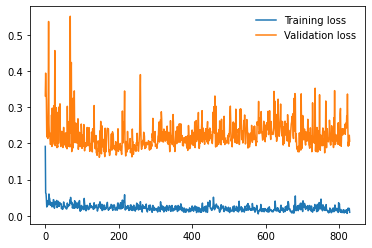

time: 143 ms


In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

### Evaluation - Test

In [ ]:
data_dir = TOTAL_IMAGES_PATH

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

time: 1.11 ms


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('jantahackathon.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 179 ms


In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 2.15 ms


In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

time: 8.69 ms


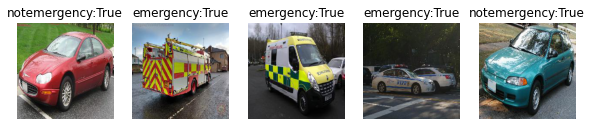

time: 361 ms


In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(testloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1), # 224 -> 222
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                 # 222 -> 111

            # Defining another 2D convolution layer
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 111 -> 109
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 109 -> 54

            # Defining another 2D convolution layer
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 54 -> 52
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 52 -> 27

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 27 -> 25
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 25 -> 12

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 12 -> 10
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 10 -> 5
        )

        self.linear_layers = Sequential(
            Linear(4 * 5 * 5, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

time: 23.3 ms
